In [1]:
#Importing all necessary libraries for this execution
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
extracted_features_df = pd.read_csv("https://github.com/KaranAgrawal1509/Urban-Sound-Classification/raw/main/Metadata/MFCCs.csv")
extracted_features_df

,class,0,1,2,3,4,5,6,7,8,...,70,71,72,73,74,75,76,77,78,79
0,dog_bark,-211.93698,62.581203,-122.813150,-60.745293,-13.893760,-29.789835,-3.978875,11.682742,12.963830,...,0.324511,1.514106,2.155947,1.580951,-1.321769,-3.285912,-3.684266,0.075934,1.307521,1.510565
1,children_playing,-417.00520,99.336624,-42.995586,51.073326,9.853778,7.969693,11.197088,1.929117,7.030397,...,-0.042892,0.442094,-0.311315,0.749658,-1.185292,0.672009,-0.203904,0.843772,-1.600764,0.216213
2,children_playing,-452.39316,112.362530,-37.578068,43.195866,8.631844,15.379366,16.882149,1.233048,6.833122,...,-0.107935,0.836189,-0.866050,0.989036,0.166954,1.828340,-0.641306,1.170986,0.242448,0.228041
3,children_playing,-406.47922,91.196600,-25.043558,42.784520,11.586844,5.054164,12.431632,-1.599949,6.656064,...,-1.563005,1.110121,-0.831134,-0.202216,-1.031376,-0.573062,-1.235855,0.603222,-0.894410,0.474847
4,children_playing,-439.63873,103.862240,-42.658787,50.690277,12.209422,15.873465,11.729268,1.533585,11.292244,...,-1.517887,0.367679,-0.645478,0.970620,-0.021970,0.859087,-1.042097,-0.116440,-0.740542,0.843810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,car_horn,-391.37210,125.362390,-40.634056,25.899754,1.730347,5.575200,16.873087,7.889440,3.488613,...,-4.102539,1.591708,1.754115,2.055592,-1.289034,-0.265378,-0.251471,-0.389598,0.717945,1.088910
8728,car_horn,-339.42715,76.409096,-35.309883,41.984035,-22.963873,-13.623511,27.856026,-9.215819,-5.666291,...,-1.366996,1.735160,-1.416760,1.599422,0.131289,0.614055,0.021380,0.767239,-1.556029,0.282285
8729,car_horn,-297.31534,102.090260,-36.751080,26.816488,-0.249390,3.960868,11.113069,1.912290,0.677115,...,1.847145,3.558338,-0.992298,-1.373567,-2.257117,-0.712134,-1.614370,1.099659,-1.268688,0.166942
8730,car_horn,-336.92386,115.313900,-44.847100,24.968985,-9.888025,-2.154685,22.700090,0.234236,-0.122909,...,-1.912338,1.955025,-2.233400,-1.820418,-2.034626,-1.908629,-3.614250,1.244706,-2.809676,0.148261


In [3]:
# Concatenate columns 0-3 separated by commas into a new column 'Features'
extracted_features_df['feature'] = extracted_features_df.loc[:, '0':'79'].apply(lambda x: ','.join(x.astype(str)), axis=1)
# Convert comma-separated values into lists of numerical values
extracted_features_df['feature'] = extracted_features_df['feature'].apply(lambda x: [float(i) for i in x.split(',')])
cols_to_drop = [str(i) for i in range(80)]
extracted_features_df.drop(cols_to_drop, axis=1, inplace=True)
extracted_features_df

,class,feature
0,dog_bark,"[-211.93698, 62.581203, -122.81315, -60.745293..."
1,children_playing,"[-417.0052, 99.336624, -42.995586, 51.073326, ..."
2,children_playing,"[-452.39316, 112.36253, -37.578068, 43.195866,..."
3,children_playing,"[-406.47922, 91.1966, -25.043558, 42.78452, 11..."
4,children_playing,"[-439.63873, 103.86224, -42.658787, 50.690277,..."
...,...,...
8727,car_horn,"[-391.3721, 125.36239, -40.634056, 25.899754, ..."
8728,car_horn,"[-339.42715, 76.409096, -35.309883, 41.984035,..."
8729,car_horn,"[-297.31534, 102.09026, -36.75108, 26.816488, ..."
8730,car_horn,"[-336.92386, 115.3139, -44.8471, 24.968985, -9..."


In [4]:
#Split the dataset into independent and dependent dataset
x=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [5]:
#Shape of Independent Features
x.shape

(8732, 80)

In [6]:
#Shape of Dependent Features
y.shape

(8732,)

In [7]:
#One-Hot Encoding Dependent features to suit the use of Neural Networks
labelencoder=LabelEncoder()
labelencoder.fit(extracted_features_df['class'])
labelencoder_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
y=to_categorical(labelencoder.fit_transform(y))

In [8]:
#Created a mapping dictionary of Label and category
labelencoder_name_mapping

{'air_conditioner': 0,
 'car_horn': 1,
 'children_playing': 2,
 'dog_bark': 3,
 'drilling': 4,
 'engine_idling': 5,
 'gun_shot': 6,
 'jackhammer': 7,
 'siren': 8,
 'street_music': 9}

In [9]:
#Data Spliting for Training and Validation Purpose
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [10]:
### No of classes
num_labels=y.shape[1]

In [11]:
# Building a deep neural network
dnn_model=Sequential()
###first layer with 800 neurons
dnn_model.add(Dense(800,input_shape=(80,x.shape[1])))
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(0.4))
###second layer with 400 neurons
dnn_model.add(Dense(400))
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(0.4))
###third layer with 200 neurons
dnn_model.add(Dense(200))
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(0.4))
###fourth layer with 100 neurons
dnn_model.add(Dense(100))
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(0.4))
###fifth layer with 50 neurons
dnn_model.add(Dense(50))
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(0.4))
###final layer with 10 neurons which is number of classes
dnn_model.add(Dense(num_labels))
dnn_model.add(Activation('softmax'))

In [12]:
#Building a LSTM
lstm_model=Sequential()
#First Layer with 80 LSTM units
lstm_model.add(LSTM(80, dropout = 0.2, return_sequences=True, input_shape=(x.shape[1], 1)))
#Second Layer with 80 LSTM units
lstm_model.add(LSTM(80, dropout = 0.2))
#Third layer of 80 Normal Neurons 
lstm_model.add(Dense(80,activation='relu'))
lstm_model.add(Dropout(0.15))
#Third layer of 40 Normal Neurons 
lstm_model.add(Dense(40,activation='relu'))
lstm_model.add(Dropout(0.15))
#Third layer of 20 Normal Neurons 
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dropout(0.15))
#Third layer of 10 Normal Neurons
lstm_model.add(Dense(num_labels,activation='softmax'))

In [13]:
#Summary of Deep Neural Network
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80, 800)           64800     
                                                                 
 activation (Activation)     (None, 80, 800)           0         
                                                                 
 dropout (Dropout)           (None, 80, 800)           0         
                                                                 
 dense_1 (Dense)             (None, 80, 400)           320400    
                                                                 
 activation_1 (Activation)   (None, 80, 400)           0         
                                                                 
 dropout_1 (Dropout)         (None, 80, 400)           0         
                                                                 
 dense_2 (Dense)             (None, 80, 200)           8

In [14]:
#Summary of LSTM
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 80)            26240     
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dense_6 (Dense)             (None, 80)                6480      
                                                                 
 dropout_5 (Dropout)         (None, 80)                0         
                                                                 
 dense_7 (Dense)             (None, 40)                3240      
                                                                 
 dropout_6 (Dropout)         (None, 40)                0         
                                                                 
 dense_8 (Dense)             (None, 20)               

In [15]:
#Custom Definations to extract evaluation metrics like Recall, Precision and F1 Score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
#Compiling Deep Model
dnn_model.compile(loss='categorical_crossentropy',metrics=['accuracy', f1_m,precision_m, recall_m], optimizer='adam')

In [17]:
#Compiling LSTM model
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy', f1_m, precision_m, recall_m])

In [18]:
#Training a Deep Neural Network, and Saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath='saved_models/dnn_audio_classification.h5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

dnn_history = dnn_model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100


46/55 [========================>.....] - ETA: 0s - loss: 5.3139 - accuracy: 0.1036 - f1_m: 0.0517 - precision_m: 0.1125 - recall_m: 0.0392


Epoch 1: val_loss improved from inf to 2.29465, saving model to saved_models/dnn_audio_classification.h5
55/55 [==============================] - 10s 16ms/step - loss: 4.8775 - accuracy: 0.1055 - f1_m: 0.0458 - precision_m: 0.1161 - recall_m: 0.0342 - val_loss: 2.2946 - val_accuracy: 0.1151 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
47/55 [========================>.....] - ETA: 0s - loss: 2.4073 - accuracy: 0.1177 - f1_m: 0.0055 - precision_m: 0.1680 - recall_m: 0.0028
Epoch 2: val_loss improved from 2.29465 to 2.28464, saving model to saved_models/dnn_audio_classification.h5
55/55 [==============================] - 0s 7ms/step - loss: 2.4000 - accuracy: 0.1165 - f1_m: 0.0053 - precision_m: 0.1708 - recall_m: 0.0027 - val_loss: 2.2846 - val_accuracy: 0.1271 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
44/55 [=======================>......] - ETA: 0s - loss: 2.3298 - accuracy: 0.1243 - f1_m:

In [19]:
#Training the LSTM Neural Network, and Saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath='saved_models/lstm_audio_classification.h5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

lstm_history = lstm_model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
53/55 [===========================>..] - ETA: 0s - loss: 2.2289 - accuracy: 0.1675 - f1_m: 5.8505e-04 - precision_m: 0.0377 - recall_m: 2.9481e-04
Epoch 1: val_loss improved from inf to 2.11459, saving model to saved_models/lstm_audio_classification.h5
55/55 [==============================] - 7s 32ms/step - loss: 2.2282 - accuracy: 0.1676 - f1_m: 8.4567e-04 - precision_m: 0.0545 - recall_m: 4.2614e-04 - val_loss: 2.1146 - val_accuracy: 0.2101 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0700 - accuracy: 0.2160 - f1_m: 0.0123 - precision_m: 0.3382 - recall_m: 0.0063
Epoch 2: val_loss improved from 2.11459 to 1.97891, saving model to saved_models/lstm_audio_classification.h5
55/55 [==============================] - 1s 14ms/step - loss: 2.0700 - accuracy: 0.2160 - f1_m: 0.0123 - precision_m: 0.3382 - recall_m: 0.0063 - val_loss: 1.9789 - val_accuracy: 0.2307 - val_f1_m: 0.

In [20]:
#Evaluating DNN Model trained on MFCCs test (unseen) data
test_accuracy=dnn_model.evaluate(x_test,y_test,verbose=0)
print("Loss of the model is = " + str(test_accuracy[0]))
print("Accuracy of the model on testing data is = " + str(test_accuracy[1]))
print("F1 Score of the model is = " + str(test_accuracy[2]))
print("Precision of the model is = " + str(test_accuracy[3]))
print("Recall of the model is = " + str(test_accuracy[4]))

Loss of the model is = 0.30420225858688354
Accuracy of the model on testing data is = 0.923297107219696
F1 Score of the model is = 0.9263097047805786
Precision of the model is = 0.9440272450447083
Recall of the model is = 0.909629225730896


In [21]:
#Evaluating LSTM Model trained on MFCCs test (unseen) data
test_accuracy=lstm_model.evaluate(x_test,y_test,verbose=0)
print("Loss of the model is = " + str(test_accuracy[0]))
print("Accuracy of the model on testing data is = " + str(test_accuracy[1]))
print("F1 Score of the model is = " + str(test_accuracy[2]))
print("Precision of the model is = " + str(test_accuracy[3]))
print("Recall of the model is = " + str(test_accuracy[4]))

Loss of the model is = 0.7365415692329407
Accuracy of the model on testing data is = 0.7618774771690369
F1 Score of the model is = 0.765968918800354
Precision of the model is = 0.8370112180709839
Recall of the model is = 0.7080442309379578


In [22]:
def plot_performance(data):
    fig, ax = plt.subplots(1,2 , figsize = (20,7))
    # summarize history for accuracy
    ax[0].plot(data.history['accuracy'])
    ax[0].plot(data.history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    ax[1].plot(data.history['loss'], label =['loss'])
    ax[1].plot(data.history['val_loss'] ,label =['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'test'], loc='upper left')
    plt.show()

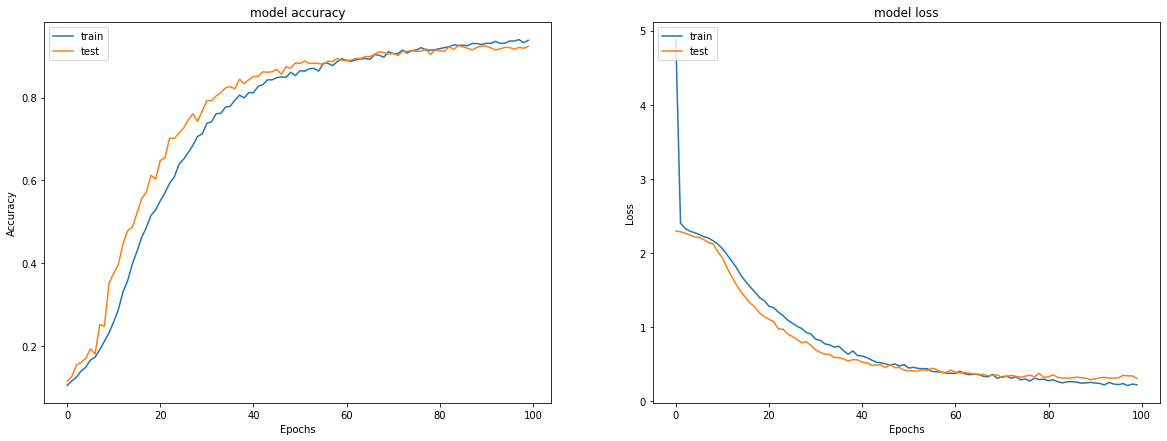

In [23]:
#Performance (Accuracy and Loss) of DNN during the training  
plot_performance(dnn_history)

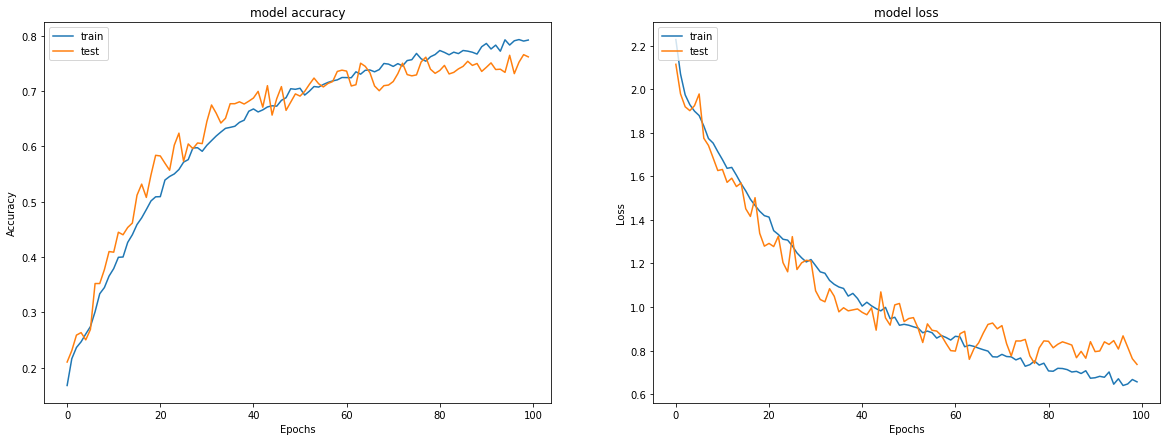

In [24]:
#Performance (Accuracy and Loss) of LSTM during the training  
plot_performance(lstm_history)

In [25]:
#Making Predictions on Test data
dnn_predictions = dnn_model.predict(x_test)
lstm_predictions = lstm_model.predict(x_test)

55/55 [==============================] - 1s 6ms/step


In [26]:
dnn_predictions = np.argmax(dnn_predictions, axis=1)
lstm_predictions = np.argmax(lstm_predictions, axis=1)
y_test=np.argmax(y_test, axis=1)

In [27]:
def get_key(val):
    for key, value in labelencoder_name_mapping.items():
        if val == value:
            return key

def mapping(predictions):
    new_list = []
    for i in predictions:
        new_list.append(get_key(i))
    return np.array(new_list)

In [28]:
#Mapping the output with actual label
dnn_predictions = mapping(dnn_predictions)
lstm_predictions = mapping(lstm_predictions)
y_test = mapping(y_test)

In [29]:
class_names = np.unique(dnn_predictions)
class_names

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype='<U16')

In [30]:
#Creating a Confusion Matrix to Evaluate the Model
import seaborn as sns
from sklearn.metrics import *
sns.set(rc={'figure.figsize':(11.7,8.27)})
dnn_matrix = confusion_matrix(y_test, dnn_predictions, labels = class_names)
lstm_matrix = confusion_matrix(y_test, lstm_predictions, labels = class_names)

In [31]:
dnn_cmtx = pd.DataFrame(
    dnn_matrix, 
    index=['true:{:}'.format(x) for x in class_names], 
    columns=['pred:{:}'.format(x) for x in class_names]
)

lstm_cmtx = pd.DataFrame(
    lstm_matrix, 
    index=['true:{:}'.format(x) for x in class_names], 
    columns=['pred:{:}'.format(x) for x in class_names]
)

<AxesSubplot:>

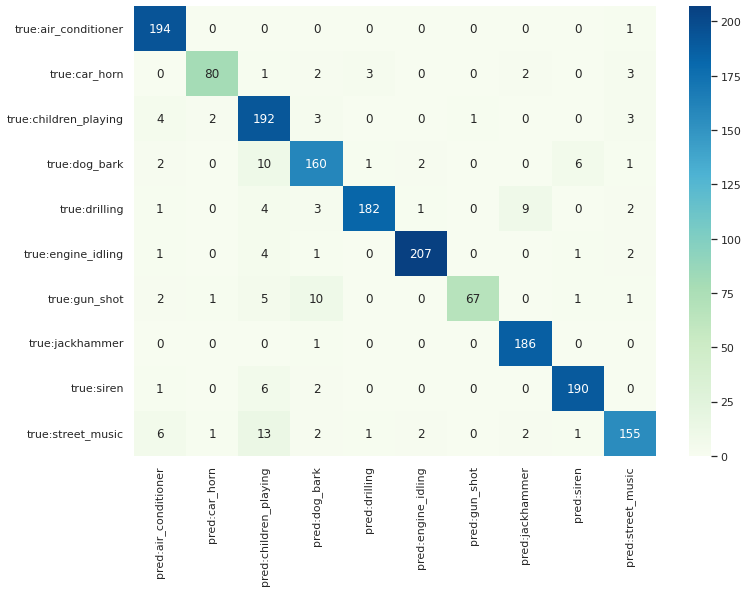

In [32]:
#Confusion Matrix for the Deep Learning Model on Features - MFCC's
sns.heatmap(dnn_cmtx, annot= True, cmap = 'GnBu', fmt='g')

<AxesSubplot:>

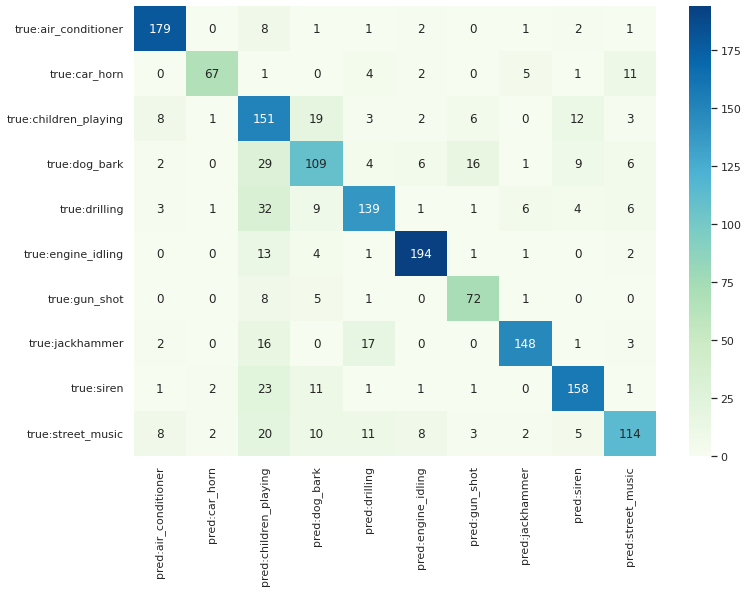

In [33]:
#Confusion Matrix for the LSTM Model on features - MFCC's
sns.heatmap(lstm_cmtx, annot= True, cmap = 'GnBu', fmt='g')

In [34]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

labelencoder=LabelEncoder()
y = labelencoder.fit_transform(y)

In [35]:
#Splitting Data into Training and Test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [36]:
#Initializing Random Forest Classifier and SVM
plt.rcParams["figure.figsize"] = (11.7,8.27)
forest_clf = RandomForestClassifier(max_depth=10, random_state=0)
svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [37]:
#Function to Train Models
def run_models(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Precision of the model is: %.3f' % precision_score(y_test, y_pred, average = 'micro'))
    print('Recall of the model is: %.3f' % recall_score(y_test, y_pred, average = 'macro'))
    print('F1 Score of the model: %.3f' % f1_score(y_test, y_pred, average = 'micro'))
    print('Accuracy of the model on testing data is: %.3f' % accuracy_score(y_test, y_pred))
    return np.array(mapping(y_pred))

In [38]:
#Evaluation of Random Forest on Test data
forest_matrix = confusion_matrix(mapping(y_test), run_models(forest_clf), labels = class_names)

Precision of the model is: 0.835
Recall of the model is: 0.818
F1 Score of the model: 0.835
Accuracy of the model on testing data is: 0.835


In [39]:
#Evaluation of SVM on Test data
svm_matrix = confusion_matrix(mapping(y_test), run_models(svm_clf), labels = class_names)

Precision of the model is: 0.896
Recall of the model is: 0.894
F1 Score of the model: 0.896
Accuracy of the model on testing data is: 0.896


In [40]:
forest_cmtx = pd.DataFrame(
    forest_matrix, 
    index=['true:{:}'.format(x) for x in class_names], 
    columns=['pred:{:}'.format(x) for x in class_names]
)

svm_cmtx = pd.DataFrame(
    svm_matrix, 
    index=['true:{:}'.format(x) for x in class_names], 
    columns=['pred:{:}'.format(x) for x in class_names]
)

<AxesSubplot:>

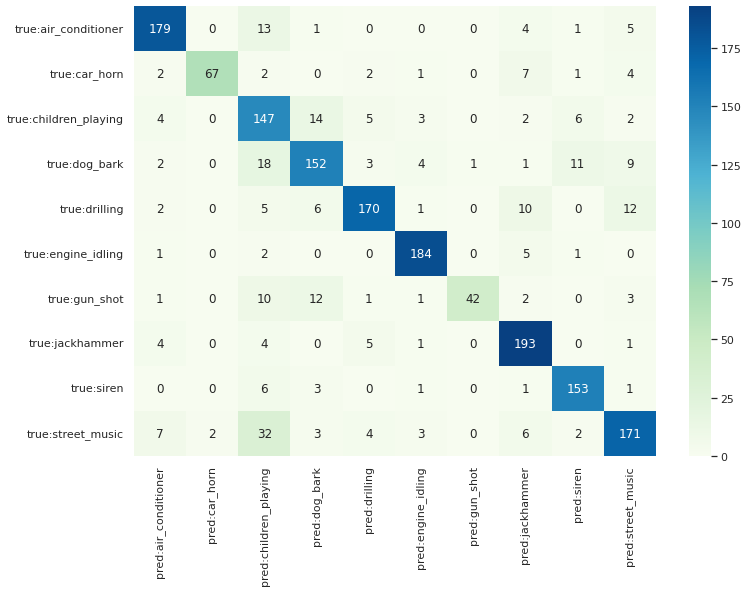

In [41]:
#Confusion Matrix for Random Forest on features - MFCC's
sns.heatmap(forest_cmtx, annot= True, cmap = 'GnBu', fmt='g')

<AxesSubplot:>

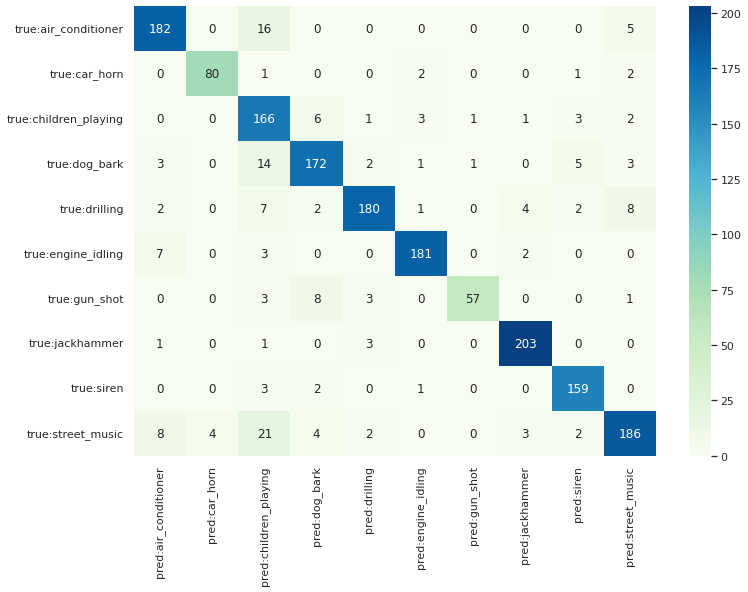

In [42]:
#Confusion Matrix for SVM on features - MFCC's
sns.heatmap(svm_cmtx, annot= True, cmap = 'GnBu', fmt='g')